### Imports

In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, linear_model, metrics, tree, \
preprocessing, ensemble, naive_bayes, feature_selection, neighbors, svm
import xgboost
import re

In [9]:
# Data Imports
train = pd.read_csv('assets/titanic_train.csv')
test = pd.read_csv('assets/titanic_test.csv')

### Data Exploration

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We have missing data for Age and Embarkation location - will have to impute missing data.
Cabin missing too much information, but "No Information" could be used as a category.

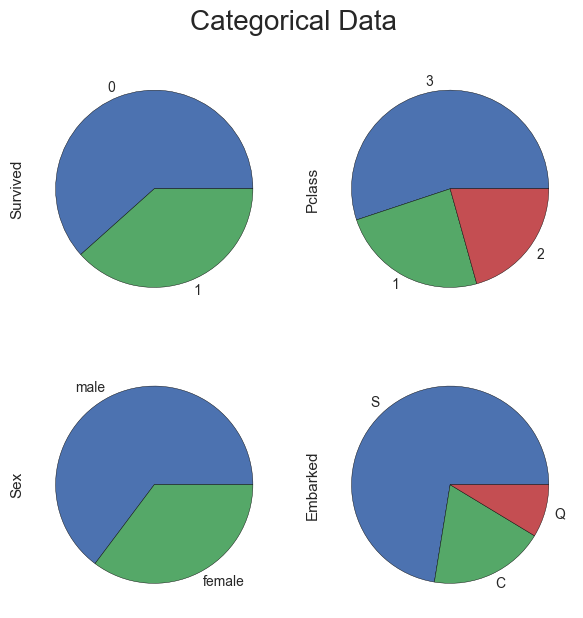

In [4]:
# visualize categorical data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, \
        sharey=False, sharex=True, figsize=(7,7))
fig.suptitle("Categorical Data", size=20)

plt.figure(figsize=(2,2))
train.Survived.value_counts().plot(kind='pie', ax=ax1)
plt.figure(figsize=(2,2))
train.Pclass.value_counts().plot(kind='pie', ax=ax2)
plt.figure(figsize=(2,2))
train.Sex.value_counts().plot(kind='pie', ax=ax3)
plt.figure(figsize=(2,2))
train.Embarked.value_counts().plot(kind='pie', ax=ax4)

Observations:
- A majority of the passengers in this sample did not survive
- Over half were 3rd class, and 1st and 2nd class made up about a quarter each
- A majority were male
- Almost 3/4 embarked from Southampton, about 1/5 Cherbourg, and just a small portion from Queenstown

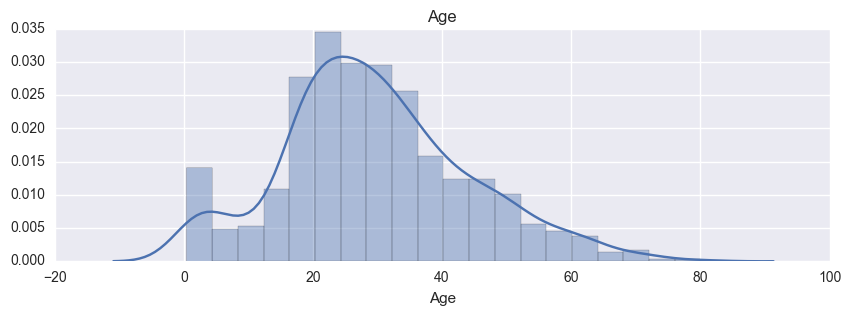

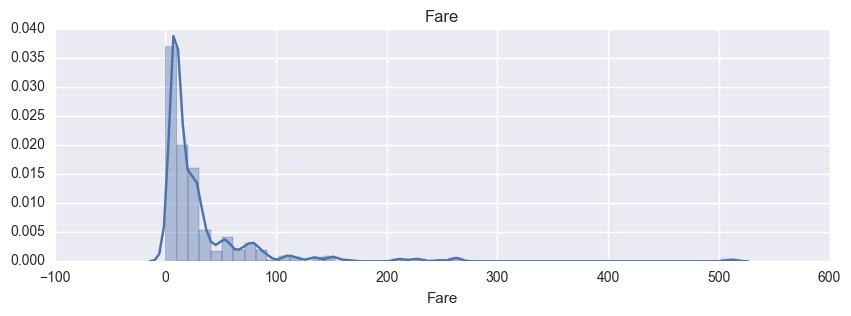

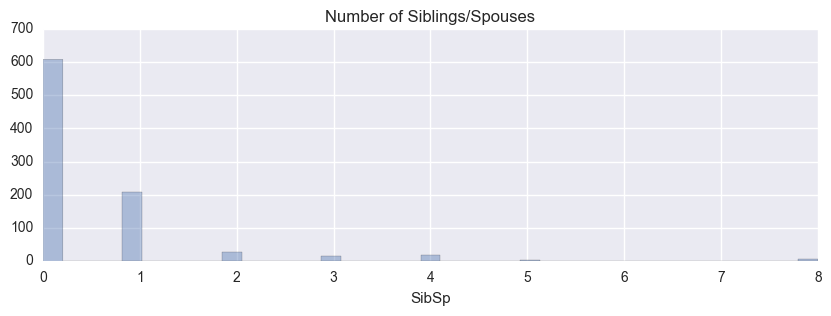

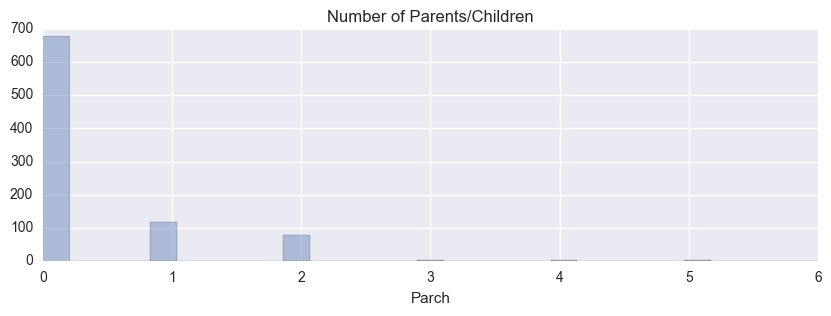

In [5]:
# Visualize numeric data
plt.figure(figsize=(10,3))
sns.distplot(train.Age[train.Age.notnull()])
plt.title('Age')
plt.show()
plt.figure(figsize=(10,3))
sns.distplot(train.Fare)
plt.title('Fare')
plt.show()
plt.figure(figsize=(10,3))
sns.distplot(train.SibSp, kde=False)
plt.title('Number of Siblings/Spouses')
plt.show()
plt.figure(figsize=(10,3))
sns.distplot(train.Parch, kde=False)
plt.title('Number of Parents/Children')
plt.show()

Observations:
- age is fairly normally distributed centered around the late 20s with a long right tail.
- Most paid around \$10 for their tickets, with the vast majority paying under \$100. However a few paid as high as \$500
- Most did not have any siblings, spouses, parents, or children on the boat, but a good chunk had 1, a few had 2, and some had as many as 8 siblings or 6 children on the boat (but this is very rare).

In [10]:
%%html
<div class='tableauPlaceholder' id='viz1480638337057' style='position: relative'>
<noscript>
<a href='#'>
<img alt='Titanic Survival' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47; \
Ti&#47;TitanicVisualizations_0&#47;Story1&#47;1_rss.png' style='border: none' />
</a>
</noscript><object class='tableauViz'  style='display:none;'>
<param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> 
<param name='site_root' value='' /><param name='name' value='TitanicVisualizations_0&#47;Story1' />
<param name='tabs' value='no' /><param name='toolbar' value='yes' />
<param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47; \
Ti&#47;TitanicVisualizations_0&#47;Story1&#47;1.png' /> 
<param name='animate_transition' value='yes' />
<param name='display_static_image' value='yes' />
<param name='display_spinner' value='yes' />
<param name='display_overlay' value='yes' />
<param name='display_count' value='yes' />
</object>
</div>                
<script type='text/javascript'>                    
var divElement = document.getElementById('viz1480638337057');                    
var vizElement = divElement.getElementsByTagName('object')[0];                    
vizElement.style.width='1020px';vizElement.style.height='733px';                    
var scriptElement = document.createElement('script');                    
scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    
vizElement.parentNode.insertBefore(scriptElement, vizElement);                
</script>

### Feature Extraction

In [11]:
# Since both Parch and Sibsp are related to family, I want to make a variable that combines them.
train['family'] = train.SibSp + train.Parch

In [12]:
# Pulling out titles from names
train['Mr'] = train.Name.apply(lambda x: 1 if re.findall('Mr\.', x) else 0)
train['Master'] = train.Name.apply(lambda x: 1 if re.findall('Master\.', x) else 0)
train['Mrs_Lady_Countess'] = train.Name.apply(lambda x: 1 if re.findall('Mrs\.', x)
                                              or re.findall('Lady\.', x)
                                              or re.findall('Countess\.', x)
                                              else 0)
train['Miss_Ms_Mme_Mlle'] = train.Name.apply(lambda x: 1 if re.findall('Miss\.', x) or re.findall('Ms\.', x) or re.findall('Mlle\.', x) or re.findall('Mme\.', x) else 0)
train['Dr_Don_Sir_Col_Capt_Jonkheer_Major'] = train.Name.apply(lambda x: 1 if re.findall('Don\.', x)
                                                               or re.findall('Dr\.', x)
                                                               or re.findall('Sir\.', x)
                                                               or re.findall('Col\.', x) 
                                                               or re.findall('Capt\.', x)
                                                               or re.findall('Jonkheer\.', x)
                                                               or re.findall('Major\.', x)
                                                               else 0)
train['Rev'] = train.Name.apply(lambda x: 1 if re.findall('Rev\.', x) else 0)
train['has()_name'] = train.Name.apply(lambda x: 1 if re.findall('\(', x) else 0)

In [13]:
# Pulling out cabin information
train.Cabin.fillna('', inplace=True)
train['Cabin_A'] = train.Cabin.apply(lambda x: 1 if re.findall('A', x) else 0)
train['Cabin_B'] = train.Cabin.apply(lambda x: 1 if re.findall('B', x) else 0)
train['Cabin_C'] = train.Cabin.apply(lambda x: 1 if re.findall('C', x) else 0)
train['Cabin_D'] = train.Cabin.apply(lambda x: 1 if re.findall('D', x) else 0)
train['Cabin_E'] = train.Cabin.apply(lambda x: 1 if re.findall('E', x) else 0)
train['Cabin_F'] = train.Cabin.apply(lambda x: 1 if re.findall('F', x) else 0)
train['Cabin_G'] = train.Cabin.apply(lambda x: 1 if re.findall('G', x) else 0)
train['Multi_Cabin'] = train.Cabin.apply(lambda x: 1 if re.findall(' ', x) else 0)
train['No_Cabin'] = train.Cabin.apply(lambda x: 1 if x=='' else 0)
train['OneDigitCabin'] = train.Cabin.apply(lambda x: 1 if re.findall('[A-Z][0-9]$', x) else 0)
train['TwoDigitCabin'] = train.Cabin.apply(lambda x: 1 if re.findall('[A-Z][0-9]{2}$', x) else 0)
train['ThreeDigitCabin'] = train.Cabin.apply(lambda x: 1 if re.findall('[A-Z][0-9]{3}$', x) else 0)

In [14]:
# Extracting some information from tickets
train['ticket_digits_count'] = train.Ticket.apply(lambda x: len(re.findall('[0-9]', x)))
train['ticket_num'] =  pd.to_numeric(train.Ticket.apply(lambda x: re.findall('[0-9]+$', x)[0] if re.findall('[0-9]+$', x) else 0))
train['LINE'] = train.Ticket.apply(lambda x: 1 if x=='LINE' else 0)
train['ticket_letters'] = train.Ticket.apply(lambda x: re.findall('(.*) ', x)[0] if re.findall('(.*) ', x) else '')

train['A5'] = train.ticket_letters.apply(lambda x: 1 if re.findall('A.*5', x) else 0)
train['A4'] = train.ticket_letters.apply(lambda x: 1 if re.findall('A.*4', x) else 0)
train['CA'] = train.ticket_letters.apply(lambda x: 1 if re.findall('C.*A', x) else 0)
train['SOTON'] = train.ticket_letters.apply(lambda x: 1 if re.findall('SOTON', x) else 0)
train['STON'] = train.ticket_letters.apply(lambda x: 1 if re.findall('STON', x) else 0)
train['F'] = train.ticket_letters.apply(lambda x: 1 if re.findall('F', x) else 0)
train['FC'] = train.ticket_letters.apply(lambda x: 1 if re.findall('F.*C', x) else 0)
train['PC'] = train.ticket_letters.apply(lambda x: 1 if re.findall('P.*C', x) else 0)
train['S'] = train.ticket_letters.apply(lambda x: 1 if re.findall('S', x) else 0)
train['Paris'] = train.ticket_letters.apply(lambda x: 1 if re.findall('[Pp][Aa][Rr][Ii][Ss]', x) else 0)
train['WC'] = train.ticket_letters.apply(lambda x: 1 if re.findall('W.*C', x) else 0)
train['tix_no_letters'] = train.ticket_letters.apply(lambda x: 1 if x=='' else 0)

In [15]:
# Make numerical and non-numerical versions of variables for different models
train['male'] = train.Sex.map({'female':0, 'male':1})
train['embarked_num'] = train.Embarked.map({'S':0, 'C':1, 'Q':2})
train['Pclass_cat'] = train.Pclass.astype(str)

In [16]:
# Repeat with Test set

test['family'] = test.SibSp + test.Parch

test['Mr'] = test.Name.apply(lambda x: 1 if re.findall('Mr\.', x) else 0)
test['Master'] = test.Name.apply(lambda x: 1 if re.findall('Master\.', x) else 0)
test['Mrs_Lady_Countess'] = test.Name.apply(lambda x: 1 if re.findall('Mrs\.', x)
                                              or re.findall('Lady\.', x)
                                              or re.findall('Countess\.', x)
                                              else 0)
test['Miss_Ms_Mme_Mlle'] = test.Name.apply(lambda x: 1 if re.findall('Miss\.', x) or re.findall('Ms\.', x) or re.findall('Mlle\.', x) or re.findall('Mme\.', x) else 0)
test['Dr_Don_Sir_Col_Capt_Jonkheer_Major'] = test.Name.apply(lambda x: 1 if re.findall('Don\.', x)
                                                               or re.findall('Dr\.', x)
                                                               or re.findall('Sir\.', x)
                                                               or re.findall('Col\.', x) 
                                                               or re.findall('Capt\.', x)
                                                               or re.findall('Jonkheer\.', x)
                                                               or re.findall('Major\.', x)
                                                               else 0)
test['Rev'] = test.Name.apply(lambda x: 1 if re.findall('Rev\.', x) else 0)
test['has()_name'] = test.Name.apply(lambda x: 1 if re.findall('\(', x) else 0)

test.Cabin.fillna('', inplace=True)
test['Cabin_A'] = test.Cabin.apply(lambda x: 1 if re.findall('A', x) else 0)
test['Cabin_B'] = test.Cabin.apply(lambda x: 1 if re.findall('B', x) else 0)
test['Cabin_C'] = test.Cabin.apply(lambda x: 1 if re.findall('C', x) else 0)
test['Cabin_D'] = test.Cabin.apply(lambda x: 1 if re.findall('D', x) else 0)
test['Cabin_E'] = test.Cabin.apply(lambda x: 1 if re.findall('E', x) else 0)
test['Cabin_F'] = test.Cabin.apply(lambda x: 1 if re.findall('F', x) else 0)
test['Cabin_G'] = test.Cabin.apply(lambda x: 1 if re.findall('G', x) else 0)
test['Multi_Cabin'] = test.Cabin.apply(lambda x: 1 if re.findall(' ', x) else 0)
test['No_Cabin'] = test.Cabin.apply(lambda x: 1 if x=='' else 0)
test['OneDigitCabin'] = test.Cabin.apply(lambda x: 1 if re.findall('[A-Z][0-9]$', x) else 0)
test['TwoDigitCabin'] = test.Cabin.apply(lambda x: 1 if re.findall('[A-Z][0-9]{2}$', x) else 0)
test['ThreeDigitCabin'] = test.Cabin.apply(lambda x: 1 if re.findall('[A-Z][0-9]{3}$', x) else 0)

test['ticket_digits_count'] = test.Ticket.apply(lambda x: len(re.findall('[0-9]', x)))
test['ticket_num'] =  pd.to_numeric(test.Ticket.apply(lambda x: re.findall('[0-9]+$', x)[0] if re.findall('[0-9]+$', x) else 0))
test['LINE'] = test.Ticket.apply(lambda x: 1 if x=='LINE' else 0)
test['ticket_letters'] = test.Ticket.apply(lambda x: re.findall('(.*) ', x)[0] if re.findall('(.*) ', x) else '')

test['A5'] = test.ticket_letters.apply(lambda x: 1 if re.findall('A.*5', x) else 0)
test['A4'] = test.ticket_letters.apply(lambda x: 1 if re.findall('A.*4', x) else 0)
test['CA'] = test.ticket_letters.apply(lambda x: 1 if re.findall('C.*A', x) else 0)
test['SOTON'] = test.ticket_letters.apply(lambda x: 1 if re.findall('SOTON', x) else 0)
test['STON'] = test.ticket_letters.apply(lambda x: 1 if re.findall('STON', x) else 0)
test['F'] = test.ticket_letters.apply(lambda x: 1 if re.findall('F', x) else 0)
test['FC'] = test.ticket_letters.apply(lambda x: 1 if re.findall('F.*C', x) else 0)
test['PC'] = test.ticket_letters.apply(lambda x: 1 if re.findall('P.*C', x) else 0)
test['S'] = test.ticket_letters.apply(lambda x: 1 if re.findall('S', x) else 0)
test['Paris'] = test.ticket_letters.apply(lambda x: 1 if re.findall('[Pp][Aa][Rr][Ii][Ss]', x) else 0)
test['WC'] = test.ticket_letters.apply(lambda x: 1 if re.findall('W.*C', x) else 0)
test['tix_no_letters'] = test.ticket_letters.apply(lambda x: 1 if x=='' else 0)

test['male'] = test.Sex.map({'female':0, 'male':1})
test['embarked_num'] = test.Embarked.map({'S':0, 'C':1, 'Q':2})
test['Pclass_cat'] = test.Pclass.astype(str)


In [17]:
# combine the two for imputation
train_test = pd.concat([train, test])

### Imputation

In [18]:
# Age Imputation -- Linear Regression Model
X_age = pd.get_dummies(train_test[(train_test.Embarked.notnull())&(train_test.Age.notnull())&(train_test.Fare.notnull())].drop(
    ['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Cabin', 'ticket_letters', 'Sex',  'embarked_num', 'Pclass'], axis=1))
y_age = train_test[(train_test.Embarked.notnull())&(train_test.Age.notnull())&(train_test.Fare.notnull())].Age

linreg = linear_model.RidgeCV()

cv=model_selection.KFold(shuffle=True, n_splits=10)
scores = model_selection.cross_val_score(linreg, X_age, y_age, cv=cv)
print 'cross-val score:', scores.mean(), '+/-', scores.std() 

cross-val score: 0.402082026036 +/- 0.0579253234424


Residuals variance increases as predicted age increases -- suggests I should use a log

In [19]:
# LOG Age Imputation -- Linear Regression Model
X_age = pd.get_dummies(train_test[(train_test.Embarked.notnull())&(train_test.Age.notnull())&(train_test.Fare.notnull())].drop(
    ['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Cabin', 'ticket_letters', 'Sex',  'embarked_num', 'Pclass'], axis=1))
y_age = np.log(train_test[(train_test.Embarked.notnull())&(train_test.Age.notnull())&(train_test.Fare.notnull())].Age)


linreg = linear_model.RidgeCV()

cv=model_selection.KFold(shuffle=True, n_splits=10)
scores = model_selection.cross_val_score(linreg, X_age, y_age, cv=cv)
print 'cross-val score:', scores.mean(), '+/-', scores.std() 

cross-val score: 0.49670907084 +/- 0.0663310140777


In [30]:
# Feature Reduction for Linear Regression
cv = model_selection.KFold(shuffle=True, n_splits=20)
rfecv = feature_selection.RFECV(linear_model.RidgeCV(), cv=cv)
rfecv.fit(X_age, y_age)
linreg_cols = rfecv.get_support()
X_age_linreg = X_age[X_age.columns[linreg_cols]]

In [31]:
# LOG Age Imputation -- Linear Regression Model with reduced features

linreg = linear_model.RidgeCV()

cv=model_selection.KFold(shuffle=True, n_splits=10)
scores = model_selection.cross_val_score(linreg, X_age_linreg, y_age, cv=cv)
print 'cross-val score:', scores.mean(), '+/-', scores.std() 

cross-val score: 0.490124467264 +/- 0.0679706131023


In [22]:
# slight change in X_age for decision tree based models
X_age = pd.get_dummies(train_test[(train_test.Embarked.notnull())&(train_test.Age.notnull())&(train_test.Fare.notnull())].drop(
    ['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Cabin', 'ticket_letters', 'Sex',  'Embarked', 'Pclass_cat'], axis=1))

In [23]:
# Random Forest feature reduction
cv = model_selection.KFold(shuffle=True, n_splits=20)
rfecv = feature_selection.RFECV(ensemble.RandomForestRegressor(), cv=cv)
rfecv.fit(X_age, y_age)
rf_cols = rfecv.get_support()
X_age_rf = X_age[X_age.columns[rf_cols]]

In [24]:
# LOG Age Imputation -- Random Forest Model

rf = ensemble.RandomForestRegressor()

cv=model_selection.KFold(shuffle=True, n_splits=10)
scores = model_selection.cross_val_score(rf, X_age_rf, y_age, cv=cv)
print 'cross-val score:', scores.mean(), '+/-', scores.std() 

cross-val score: 0.494583733935 +/- 0.101045758367


In [25]:
# Decision Tree feature reduction
cv = model_selection.KFold(shuffle=True, n_splits=5)
rfecv = feature_selection.RFECV(tree.DecisionTreeRegressor(max_depth=4), cv=cv)
rfecv.fit(X_age, y_age)
dt_cols = rfecv.get_support()
X_age_dt = X_age[X_age.columns[dt_cols]]

In [26]:
# LOG Age Imputation -- Decision Tree Model
dt = tree.DecisionTreeRegressor(max_depth=4)

cv=model_selection.KFold(shuffle=True, n_splits=10)
scores = model_selection.cross_val_score(dt, X_age_dt, y_age, cv=cv)
print 'cross-val score:', scores.mean(), '+/-', scores.std() 

cross-val score: 0.525633815673 +/- 0.0977886428267


In [27]:
# XGBoost feature reduction
cv = model_selection.KFold(shuffle=True, n_splits=5)
rfecv = feature_selection.RFECV(xgboost.XGBRegressor(max_depth=4), cv=cv)
rfecv.fit(X_age, y_age)
xgb_cols = rfecv.get_support()
X_age_xgb = X_age[X_age.columns[xgb_cols]]

In [28]:
# LOG Age Imputation -- XGBoost Model

xgb = xgboost.XGBRegressor()

cv=model_selection.KFold(shuffle=True, n_splits=10)
scores = model_selection.cross_val_score(xgb, X_age_xgb, y_age, cv=cv)
print 'cross-val score:', scores.mean(), '+/-', scores.std() 

cross-val score: 0.605306376538 +/- 0.0433269433837


In [29]:
# Ensemble of the models
pred_linreg = model_selection.cross_val_predict(linreg, X_age_linreg, y_age)
pred_dt = model_selection.cross_val_predict(dt, X_age_dt, y_age)
pred_rf = model_selection.cross_val_predict(rf, X_age_rf, y_age)
pred_xgb = model_selection.cross_val_predict(xgb, X_age_xgb, y_age)

overall_pred = (pred_linreg + pred_dt + pred_rf + pred_xgb)/4
print 'linreg', metrics.r2_score(y_age, pred_linreg)
print 'dt', metrics.r2_score(y_age, pred_dt)
print 'rf', metrics.r2_score(y_age, pred_rf)
print 'xgb', metrics.r2_score(y_age, pred_xgb)
print 'overall', metrics.r2_score(y_age, overall_pred)

linreg 0.504503207942
dt 0.555464775465
rf 0.540500192014
xgb 0.596047364297
overall 0.609649027592


In [32]:
#Application of the ensembled version to impute

linreg.fit(X_age_linreg, y_age)
rf.fit(X_age_rf, y_age)
dt.fit(X_age_dt, y_age)
xgb.fit(X_age_xgb, y_age)

X_age_i = pd.get_dummies(train_test[(train_test.Embarked.notnull())&(train_test.Age.isnull())&(train_test.Fare.notnull())].drop(
    ['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Cabin', 'ticket_letters', 'Sex',  'embarked_num', 'Pclass'], axis=1))
y_age_i = np.log(train_test[(train_test.Embarked.notnull())&(train_test.Age.isnull())&(train_test.Fare.notnull())].Age)

X_age_i_linreg = X_age_i[X_age_i.columns[linreg_cols]]
pred_linreg = linreg.predict(X_age_i_linreg)

X_age_i = pd.get_dummies(train_test[(train_test.Embarked.notnull())&(train_test.Age.isnull())&(train_test.Fare.notnull())].drop(
    ['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Cabin', 'ticket_letters', 'Sex',  'Embarked', 'Pclass_cat'], axis=1))

X_age_i_dt = X_age_i[X_age_i.columns[dt_cols]]
pred_dt = dt.predict(X_age_i_dt)

X_age_i_rf = X_age_i[X_age_i.columns[rf_cols]]
pred_rf = rf.predict(X_age_i_rf)

X_age_i_xgb = X_age_i[X_age_i.columns[xgb_cols]]
pred_xgb = xgb.predict(X_age_i_xgb)

overall_pred = (pred_linreg + pred_dt + pred_rf + pred_xgb)/4

//anaconda/envs/py27/lib/python2.7/site-packages/pandas/indexes/base.py:1434: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 45 but corresponding boolean dimension is 41
  result = getitem(key)


In [33]:
#Put imputed ages in to the original data frames
age_predictions = pd.DataFrame(y_age_i)
age_predictions['predicted_age'] = np.e**overall_pred

train_imputed = pd.merge(train, age_predictions.iloc[0:177], how='left', left_index=True, right_index=True)
test_imputed = pd.merge(test, age_predictions.iloc[177:], how='left', left_index=True, right_index=True)

train_imputed['age_with_imputes'] = train_imputed.Age_x.fillna(0) + train_imputed.predicted_age.fillna(0)
test_imputed['age_with_imputes'] = test_imputed.Age_x.fillna(0) + test_imputed.predicted_age.fillna(0)

train_imputed.drop(['Age_y', 'predicted_age'], axis=1, inplace=True)
test_imputed.drop(['Age_y', 'predicted_age'], axis=1, inplace=True)

train_imputed.rename_axis({'Age_x':'Age'}, axis=1, inplace=True)
test_imputed.rename_axis({'Age_x':'Age'}, axis=1, inplace=True)

In [34]:
# Impute the one missing Fare
X_fare = pd.get_dummies(train_test[(train_test.Embarked.notnull())&(train_test.Age.notnull())&(train_test.Fare.notnull())&(train_test.Fare !=0)&(train_test.Fare <400)].drop(
    ['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Cabin', 'ticket_letters', 'Sex',  'Embarked', 'Pclass_cat', 'Fare'], axis=1))
y_fare = np.log(train_test[(train_test.Embarked.notnull())&(train_test.Age.notnull())&(train_test.Fare.notnull())&(train_test.Fare !=0)&(train_test.Fare <400)].Fare)

xgb_fare = xgboost.XGBRegressor(max_depth=6)

cv=model_selection.KFold(shuffle=True, n_splits=10)
scores = model_selection.cross_val_score(xgb_fare, X_fare, y_fare, cv=cv)
print 'cross-val score:', scores.mean(), '+/-', scores.std() 

cross-val score: 0.889722364727 +/- 0.0391320237688


In [35]:
# Apply
xgb_fare.fit(X_fare, y_fare)

X_fare_topredict = pd.get_dummies(train_test[(train_test.Embarked.notnull())&(train_test.Age.notnull())&(train_test.Fare.isnull())].drop(
    ['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Cabin', 'ticket_letters', 'Sex',  'Embarked', 'Pclass_cat', 'Fare'], axis=1))
imputation = np.e**xgb_fare.predict(X_fare_topredict)[0]


test_imputed.Fare.fillna(imputation, inplace=True)

## Predict Survival

In [36]:
# XGBoost Model
X = train_imputed[(train_imputed.Embarked.notnull())].drop(['PassengerId', 'Survived', 
                                                            'Name', 'Age', 'Ticket', 
                                                            'Cabin', 'ticket_letters', 
                                                            'Sex',  'Embarked', 
                                                            'Pclass_cat'], axis=1)
y = train_imputed[(train_imputed.Embarked.notnull())].Survived

xgb = xgboost.XGBClassifier(max_depth=8)

cv = model_selection.StratifiedKFold(shuffle=True, n_splits=10)
print model_selection.cross_val_score(xgb, X, y, cv=cv).mean(), '+/-', model_selection.cross_val_score(xgb, X, y, cv=cv).std()

0.852591930541 +/- 0.0311818980019


In [37]:
# Random Forest Model
X = train_imputed[(train_imputed.Embarked.notnull())].drop(['PassengerId', 'Survived', 
                                                            'Name', 'Age', 'Ticket', 
                                                            'Cabin', 'ticket_letters', 
                                                            'Sex',  'Embarked', 
                                                            'Pclass_cat'], axis=1)
y = train_imputed[(train_imputed.Embarked.notnull())].Survived

rf = ensemble.RandomForestClassifier()

cv = model_selection.StratifiedKFold(shuffle=True, n_splits=10)
print model_selection.cross_val_score(rf, X, y, cv=cv).mean(), '+/-', model_selection.cross_val_score(rf, X, y, cv=cv).std()

0.813317160368 +/- 0.0247201332366


In [38]:
# Linear Regression Model Trial 1
X = pd.get_dummies(train_imputed[(train_imputed.Embarked.notnull())].drop(['PassengerId', 'Survived', 
                                                            'Name', 'Age', 'Ticket', 
                                                            'Cabin', 'ticket_letters', 
                                                            'Sex',  'embarked_num', 
                                                            'Pclass'], axis=1))
y = train_imputed[(train_imputed.Embarked.notnull())].Survived

logreg = linear_model.LogisticRegressionCV()

cv = model_selection.StratifiedKFold(shuffle=True, n_splits=10)
print model_selection.cross_val_score(logreg, X, y, cv=cv).mean(), '+/-', model_selection.cross_val_score(logreg, X, y, cv=cv).std()

0.655720122574 +/- 0.0411923901716


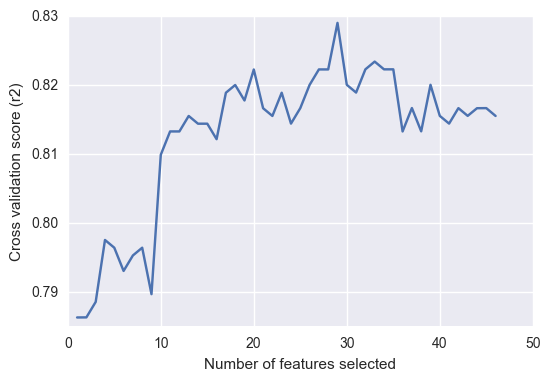

In [39]:
# Linear Regression Feature Reduction
cv = model_selection.KFold(shuffle=True, n_splits=10)
logreg = linear_model.LogisticRegressionCV(penalty='l1', solver='liblinear')

rfecv = feature_selection.RFECV(logreg, cv=cv)
rfecv.fit(X, y)
logreg_cols = rfecv.get_support()
X_logreg = X[X.columns[logreg_cols]]

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [40]:
# Linear Regression with Reduced Features
X = pd.get_dummies(train_imputed[(train_imputed.Embarked.notnull())].drop(['PassengerId', 'Survived', 
                                                            'Name', 'Age', 'Ticket', 
                                                            'Cabin', 'ticket_letters', 
                                                            'Sex',  'embarked_num', 
                                                            'Pclass'], axis=1))
y = train_imputed[(train_imputed.Embarked.notnull())].Survived

logreg = linear_model.LogisticRegressionCV(penalty='l1', solver='liblinear')

cv = model_selection.StratifiedKFold(shuffle=True, n_splits=10)
print model_selection.cross_val_score(logreg, X_logreg, y, cv=cv).mean(), '+/-', model_selection.cross_val_score(linreg, X_logreg, y, cv=cv).std()

0.827860061287 +/- 0.125158423541


In [41]:
# Ensemble of the three models
X = pd.get_dummies(train_imputed[(train_imputed.Embarked.notnull())].drop(['PassengerId', 'Survived', 
                                                            'Name', 'Age', 'Ticket', 
                                                            'Cabin', 'ticket_letters', 
                                                            'Sex',  'embarked_num', 
                                                            'Pclass'], axis=1))
pred_logreg = model_selection.cross_val_predict(logreg, X_logreg, y, method='predict_proba')[:,1]
prediction_logreg = model_selection.cross_val_predict(logreg, X_logreg, y)
X = train_imputed[(train_imputed.Embarked.notnull())].drop(['PassengerId', 'Survived', 
                                                            'Name', 'Age', 'Ticket', 
                                                            'Cabin', 'ticket_letters', 
                                                            'Sex',  'Embarked', 
                                                            'Pclass_cat'], axis=1)
pred_rf = model_selection.cross_val_predict(rf, X, y, method='predict_proba')[:,1]
prediction_rf = model_selection.cross_val_predict(rf, X, y)
pred_xgb = model_selection.cross_val_predict(xgb, X, y, method='predict_proba')[:,1]
prediction_xgb = model_selection.cross_val_predict(xgb, X, y)

overall_pred = (pred_logreg + pred_rf + pred_xgb)/3
overall_prediction = [1 if p>.5 else 0 for p in overall_pred]
print 'logreg', metrics.accuracy_score(y, prediction_logreg)
print 'rf', metrics.accuracy_score(y, prediction_rf)
print 'xgb', metrics.accuracy_score(y, prediction_xgb)
print 'overall', metrics.accuracy_score(y, overall_prediction)
y_pred = [1 if p>.5 else 0 for p in overall_pred]

logreg 0.818897637795
rf 0.81664791901
xgb 0.840269966254
overall 0.833520809899


In [43]:
# classification report
print metrics.classification_report(y, y_pred)

             precision    recall  f1-score   support

          0       0.84      0.90      0.87       549
          1       0.82      0.72      0.77       340

avg / total       0.83      0.83      0.83       889



The classification metrics tell us:
- this model correctly predicts 91% of the casualties and 74% of the survivors. 
- 85% of the people this model predicted would be casualties were in fact casualties, and 83% of people who the model predicted would survive did in fact survive

It also tells us the harmonic balance of these metrics, which is 84% overall.

In [44]:
# confusion matrix
actual_vs_cross_val_pred = pd.DataFrame([y_pred, list(y.values)]).transpose()
actual_vs_cross_val_pred.columns = ['cross_val_pred', 'actual']
pd.crosstab(actual_vs_cross_val_pred.cross_val_pred, actual_vs_cross_val_pred.actual)

actual,0,1
cross_val_pred,,
0,496,95
1,53,245


The confusion matrix tells us that:
- The model correctly identified 499 passengers as dying
- The model correctly identified 251 passengers as surviving
- The model incorrectly identified 50 passengers as surviving when they really died
- The model incorrectly identified 89 passengers as dying when they really survived.

AUC: 0.876915246973


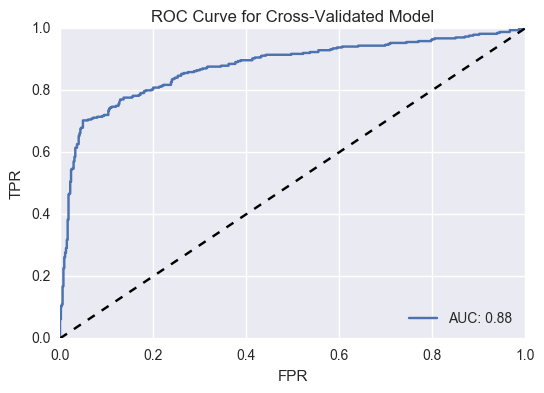

In [45]:
# ROC Curve to understand how it does at different thresholds
y_score = overall_pred
fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
print 'AUC:', metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC: {:.2}'.format(metrics.auc(fpr, tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Cross-Validated Model')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')

The ROC curve is another way to measure model performance that takes into account how it performs at different thresholds. The Area Under the Curve (AUC) is 0.88, which is very good - a worthless model has a score of 0.5 and a perfect model has a score of 1.0, and this is much closer to 1 than .5.

In [46]:
# Application on Test Set, for Kaggle
logreg.fit(X_logreg, y)
xgb.fit(X, y)
rf.fit(X, y)

X_test_a = pd.get_dummies(test_imputed.drop(['PassengerId', 'Name', 'Age', 'Ticket', 
                                                            'Cabin', 'ticket_letters', 
                                                            'Sex',  'embarked_num', 
                                                            'Pclass'], axis=1))
X_logreg_test = X_test_a[X_test_a.columns[logreg_cols]]

X_test = test_imputed.drop(['PassengerId', 'Name', 'Age', 'Ticket', 
                                                            'Cabin', 'ticket_letters', 
                                                            'Sex',  'Embarked', 
                                                            'Pclass_cat'], axis=1)
y_prob_log = logreg.predict_proba(X_logreg_test)[:,1]
y_prob_xgb = xgb.predict_proba(X_test)[:,1]
y_prob_rf = rf.predict_proba(X_test)[:,1]
y_prob_avg = (y_prob_log + y_prob_xgb + y_prob_rf)/3
y_pred = [1 if p>.5 else 0 for p in y_prob_avg]

In [47]:
sample = pd.read_csv('assets/gendermodel.csv', index_col='PassengerId')

In [48]:
sample.Survived = y_pred

In [49]:
sample.to_csv('test_predictions.csv')